<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Embeddings-with-PTB-Data-in-TensorFlow" data-toc-modified-id="Embeddings-with-PTB-Data-in-TensorFlow-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Embeddings with PTB Data in TensorFlow</a></span><ul class="toc-item"><li><span><a href="#Load-and-Prepare-PTB-data" data-toc-modified-id="Load-and-Prepare-PTB-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load and Prepare PTB data</a></span></li><li><span><a href="#Train-the-skip-gram-model-for-PTB-Data-in-TensorFlow" data-toc-modified-id="Train-the-skip-gram-model-for-PTB-Data-in-TensorFlow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train the skip-gram model for PTB Data in TensorFlow</a></span></li></ul></li><li><span><a href="#Embeddings-with-Text8-data-in-TensorFlow" data-toc-modified-id="Embeddings-with-Text8-data-in-TensorFlow-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embeddings with Text8 data in TensorFlow</a></span></li><li><span><a href="#skip-gram-model-with-Keras" data-toc-modified-id="skip-gram-model-with-Keras-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>skip-gram model with Keras</a></span></li><li><span><a href="#word2vec-or-embeddings-visualisation-using-TensorBoard" data-toc-modified-id="word2vec-or-embeddings-visualisation-using-TensorBoard-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>word2vec or embeddings visualisation using TensorBoard</a></span></li><li><span><a href="#The-word2id-and-id2word-code-explained" data-toc-modified-id="The-word2id-and-id2word-code-explained-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The word2id and id2word code explained</a></span></li></ul></div>

# Word Vectors and Embeddings in TensorFlow and Keras <a class="tocSkip">

In [1]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

NumPy:1.13.1
Matplotlib:2.1.0
TensorFlow:1.4.1


In [2]:
DATASETSLIB_HOME = os.path.join(os.path.expanduser('~'),'dl-ts','datasetslib')
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
from datasetslib import nputil
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Embeddings with PTB Data in TensorFlow

## Load and Prepare PTB data

In [3]:
from datasetslib.ptb import PTBSimple
ptb = PTBSimple()
# downloads data, converts words to ids, converts files to a list of ids
ptb.load_data()
print('Train :', ptb.part['train'][0:5])
print('Test: ', ptb.part['test'][0:5])
print('Valid: ', ptb.part['valid'][0:5])
print('Vocabulary Length = ', ptb.vocab_len)

Already exists: /home/armando/datasets/ptb-simple/simple-examples.tgz
Train : [9970 9971 9972 9974 9975]
Test:  [102  14  24  32 752]
Valid:  [1132   93  358    5  329]
Vocabulary Length =  10000


In [4]:
ptb.skip_window = 2
ptb.reset_index()
# in CBOW input is the context word and output is the target word
y_batch, x_batch = ptb.next_batch_cbow()

print('The CBOW pairs : context,target')
for i in range(5 * ptb.skip_window):
    print('(', [ptb.id2word[x_i] for x_i in x_batch[i]],
          ',', y_batch[i], ptb.id2word[y_batch[i]], ')')

The CBOW pairs : context,target
( ['aer', 'banknote', 'calloway', 'centrust'] , 9972 berlitz )
( ['banknote', 'berlitz', 'centrust', 'cluett'] , 9974 calloway )
( ['berlitz', 'calloway', 'cluett', 'fromstein'] , 9975 centrust )
( ['calloway', 'centrust', 'fromstein', 'gitano'] , 9976 cluett )
( ['centrust', 'cluett', 'gitano', 'guterman'] , 9980 fromstein )
( ['cluett', 'fromstein', 'guterman', 'hydro-quebec'] , 9981 gitano )
( ['fromstein', 'gitano', 'hydro-quebec', 'ipo'] , 9982 guterman )
( ['gitano', 'guterman', 'ipo', 'kia'] , 9983 hydro-quebec )
( ['guterman', 'hydro-quebec', 'kia', 'memotec'] , 9984 ipo )
( ['hydro-quebec', 'ipo', 'memotec', 'mlx'] , 9986 kia )


In [5]:
ptb.skip_window = 2
ptb.reset_index()
# in skip-gram input is the target word and output is the context word
x_batch, y_batch = ptb.next_batch_sg()

print('The skip-gram pairs : target,context')
for i in range(5 * ptb.skip_window):
    print('(', x_batch[i], ptb.id2word[x_batch[i]],
          ',', y_batch[i], ptb.id2word[y_batch[i]], ')')

The skip-gram pairs : target,context
( 9972 berlitz , 9970 aer )
( 9972 berlitz , 9971 banknote )
( 9972 berlitz , 9974 calloway )
( 9972 berlitz , 9975 centrust )
( 9974 calloway , 9971 banknote )
( 9974 calloway , 9972 berlitz )
( 9974 calloway , 9975 centrust )
( 9974 calloway , 9976 cluett )
( 9975 centrust , 9972 berlitz )
( 9975 centrust , 9974 calloway )


In [6]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [64 58 59  4 69 53 31 77]


## Train the skip-gram model for PTB Data in TensorFlow

In [7]:
batch_size = 128
embedding_size = 128  
n_negative_samples = 64
ptb.skip_window=2

In [8]:
# clear the effects of previous sessions in the Jupyter Notebook
tf.reset_default_graph()

In [9]:
inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size])
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1])
inputs_valid = tf.constant(x_valid, dtype=tf.int32)

In [10]:
# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word
# in the vocbulary

embed_dist = tf.random_uniform(shape=[ptb.vocab_len, embedding_size],
                               minval=-1.0,
                               maxval=1.0
                               )
embed_matrix = tf.Variable(embed_dist,
                           name='embed_matrix'
                           )
# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

In [11]:
# define noise-contrastive estimation (NCE) loss layer

nce_dist = tf.truncated_normal(shape=[ptb.vocab_len, embedding_size],
                               stddev=1.0 /
                               tf.sqrt(embedding_size * 1.0)
                               )
nce_w = tf.Variable(nce_dist)
nce_b = tf.Variable(tf.zeros(shape=[ptb.vocab_len]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=ptb.vocab_len
                                     )
                      )

In [12]:
# Compute the cosine similarity between validation set samples
# and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, 
                             keep_dims=True))
normalized_embeddings = embed_matrix / norm
embed_valid = tf.nn.embedding_lookup(normalized_embeddings, 
                                     inputs_valid)
similarity = tf.matmul(
    embed_valid, normalized_embeddings, transpose_b=True)

In [13]:
n_epochs = 10
learning_rate = 0.9
n_batches = ptb.n_batches_wv()
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil.to2d(y_batch, unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches
        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)

        # print closest words to validation set at end of every epoch
        similarity_scores = tfs.run(similarity)
        top_k = 5
        for i in range(valid_size):
            similar_words = (-similarity_scores[i, :]
                             ).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(
                ptb.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(
                    similar_str, ptb.id2word[similar_words[k]])
            print(similar_str)
    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  0 :  114.686313165
Similar to we: japanese, premium, designer, whose, 's,
Similar to been: ', exports, plot, of, week,
Similar to also: country, types, or, ltd., spent,
Similar to of: are, $, own, stiff, u.s.,
Similar to last: satisfy, to, by, purchasing, paid,
Similar to u.s.: had, fact, of, under, before,
Similar to an: <unk>, country, members, stock, so,
Similar to trading: see, around, came, seeking, $,

Average loss after epoch  1 :  48.5942172454
Similar to we: details, japanese, designer, whose, premium,
Similar to been: ', exports, week, plot, english,
Similar to also: types, country, squeezed, ltd., spent,
Similar to of: are, stiff, $, utilities, effectively,
Similar to last: portugal, americans, satisfy, fans, one,
Similar to u.s.: had, fact, sooner, under, before,
Similar to an: <unk>, members, consider, country, billions,
Similar to trading: came, see, around, receiving, seeking,

Average loss after epoch  2 :  28.3028867856
Similar to we: details

In [14]:
n_epochs = 5000
learning_rate = 0.9

n_batches = ptb.n_batches_wv()

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0
    for epoch in range(n_epochs):
        epoch_loss = 0
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil.to2d(y_batch, unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches
        if epoch + 1 % 1000 == 0:
            print('epoch done: ', epoch)
    print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)

    # print closest words to validation set at end of training

    similarity_scores = tfs.run(similarity)
    top_k = 5
    for i in range(valid_size):
        similar_words = (-similarity_scores[i, :]).argsort()[1:top_k + 1]
        similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
        for k in range(top_k):
            similar_str = '{0:} {1:},'.format(
                similar_str, ptb.id2word[similar_words[k]])
        print(similar_str)

    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  4999 :  2.76887808091
Similar to we: champagne, permanent, she, over-the-counter, weeks,
Similar to been: precedent, deemed, visit, duty-free, conference,
Similar to also: attention, introduce, argue, index, extremely,
Similar to of: providing, grace, instruments, N, t.,
Similar to last: donoghue, agreed, march, swing, chief,
Similar to u.s.: automobile, fannie, soul, success, classified,
Similar to an: authority, outlawed, donaldson, stepping, eligible,
Similar to trading: money, boston, plus, uses, N,


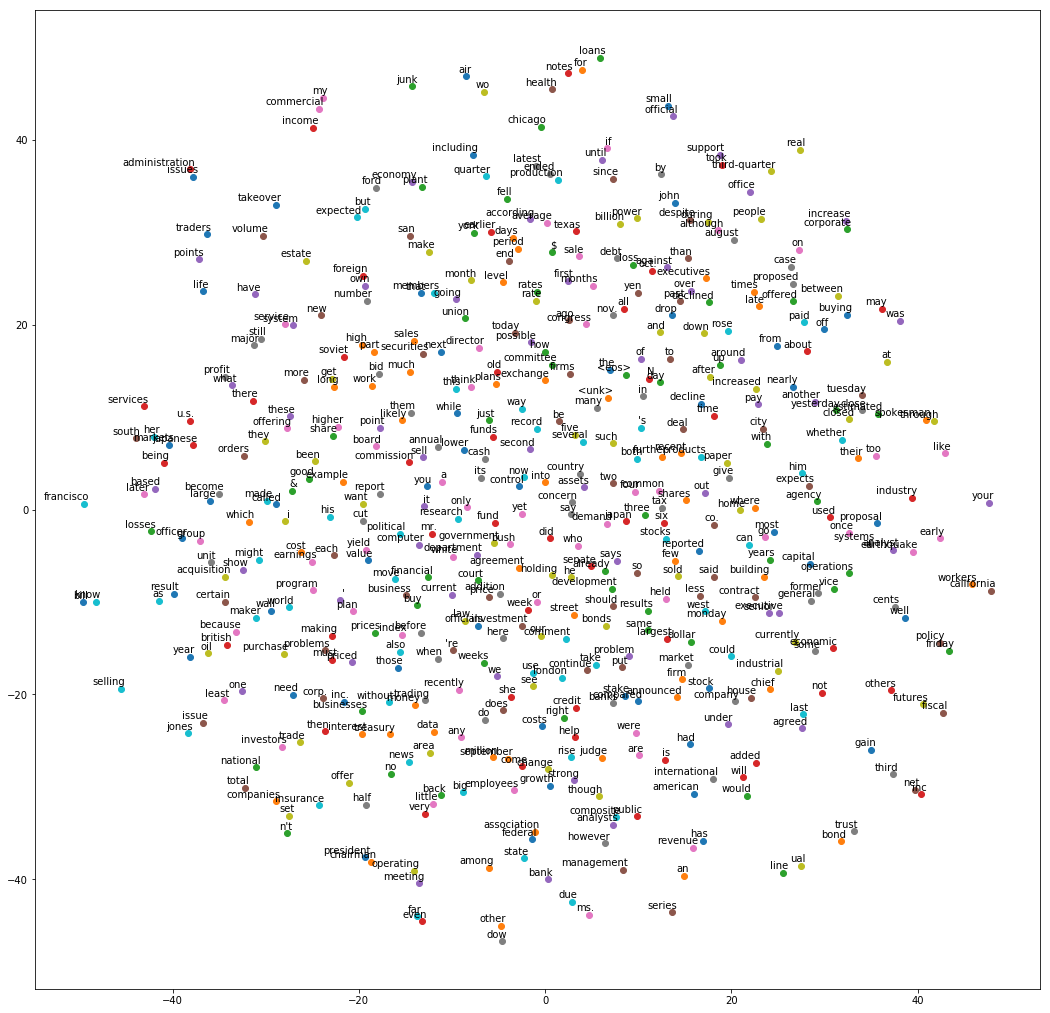

In [15]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(
        labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2,
            init='pca', n_iter=5000, method='exact')
n_embeddings = 500
low_dim_embeddings = tsne.fit_transform(final_embeddings[:n_embeddings, :])
labels = [ptb.id2word[i] for i in range(n_embeddings)]

plot_with_labels(low_dim_embeddings, labels)

# Embeddings with Text8 data in TensorFlow

In [16]:
from datasetslib.text8 import Text8
text8 = Text8()
# downloads data, converts words to ids, converts files to a list of ids
text8.load_data()
print('Train:', text8.part['train'][0:5])
# print(text8.part['test'][0:5])
# print(text8.part['valid'][0:5])
print('Vocabulary Length = ', text8.vocab_len)

Already exists: /home/armando/datasets/text8/text8.zip
Train: [5233 3083   11    5  194]
Vocabulary Length =  253854


In [17]:
text8.skip_window = 2
text8.reset_index()
# in CBOW input is the context word and output is the target word
y_batch, x_batch = text8.next_batch_cbow()

print('The CBOW pairs : context,target')
for i in range(5 * text8.skip_window):
    print('(', [text8.id2word[x_i] for x_i in x_batch[i]],
          ',', y_batch[i], text8.id2word[y_batch[i]], ')')

The CBOW pairs : context,target
( ['anarchism', 'originated', 'a', 'term'] , 11 as )
( ['originated', 'as', 'term', 'of'] , 5 a )
( ['as', 'a', 'of', 'abuse'] , 194 term )
( ['a', 'term', 'abuse', 'first'] , 1 of )
( ['term', 'of', 'first', 'used'] , 3133 abuse )
( ['of', 'abuse', 'used', 'against'] , 45 first )
( ['abuse', 'first', 'against', 'early'] , 58 used )
( ['first', 'used', 'early', 'working'] , 155 against )
( ['used', 'against', 'working', 'class'] , 127 early )
( ['against', 'early', 'class', 'radicals'] , 741 working )


In [18]:
text8.skip_window = 2
text8.reset_index()
# in skip-gram input is the target word and output is the context word
x_batch, y_batch = text8.next_batch_sg()

print('The skip-gram pairs : target,context')
for i in range(5 * text8.skip_window):
    print('(', x_batch[i], text8.id2word[x_batch[i]],
          ',', y_batch[i], text8.id2word[y_batch[i]], ')')

The skip-gram pairs : target,context
( 11 as , 5233 anarchism )
( 11 as , 3083 originated )
( 11 as , 5 a )
( 11 as , 194 term )
( 5 a , 3083 originated )
( 5 a , 11 as )
( 5 a , 194 term )
( 5 a , 1 of )
( 194 term , 11 as )
( 194 term , 5 a )


In [19]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [20 49 77  5 19  7 10 75]


In [20]:
batch_size = 128
embedding_size = 128  
n_negative_samples = 64
text8.skip_window=2

In [21]:
# clear the effects of previous sessions in the Jupyter Notebook
tf.reset_default_graph()

In [22]:
inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size])
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1])
inputs_valid = tf.constant(x_valid, dtype=tf.int32)

In [23]:
# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word in the vocbulary

embed_matrix = tf.Variable(tf.random_uniform(shape=[text8.vocab_len, embedding_size], 
                                           minval = -1.0, 
                                           maxval = 1.0
                                          ),
                           name='embed_matrix'
                        )

# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

In [24]:
# define noise-contrastive estimation (NCE) loss function

nce_w = tf.Variable(tf.truncated_normal(shape=[text8.vocab_len, embedding_size],
                                        stddev=1.0 / tf.sqrt(embedding_size*1.0)
                                       )
                   )
nce_b = tf.Variable(tf.zeros(shape=[text8.vocab_len]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=text8.vocab_len
                                    )
                     )

In [25]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keep_dims=True))
normalized_embeddings = embed_matrix / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, inputs_valid)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [26]:
n_epochs = 50
learning_rate = 0.9
text8.reset_index()
n_batches = text8.n_batches_wv()

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as tfs:
    tf.global_variables_initializer().run()

    for epoch in range(n_epochs):
        epoch_loss = 0
        for step in range(n_batches):
            x_batch, y_batch = text8.next_batch_sg()
            y_batch = nputil.to2d(y_batch,unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}

            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches 

        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)
        
        # validating at end of every epoch

    
        similarity_scores = tfs.run(similarity)
        for i in range(valid_size):
            top_k = 5
            similar_words = (-similarity_scores[i, :]).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(text8.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(similar_str, text8.id2word[similar_words[k]])
            print(similar_str)
        
    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  0 :  135.827208625
Similar to four: tissue, lechuguilla, straw, celsius, victoriae,
Similar to all: autistic, males, africa, gland, limited,
Similar to between: taxes, mormon, library, vivipara, declines,
Similar to a: the, carnival, of, lechuguilla, with,
Similar to that: leakey, basis, vivipara, but, staple,
Similar to zero: anna, launch, gland, two, one,
Similar to is: leadership, territories, parietal, taxes, and,
Similar to no: tissue, dagny, administration, ships, mirabilis,

Average loss after epoch  1 :  70.5671460077
Similar to four: one, zero, gb, eight, two,
Similar to all: gb, the, and, stronger, rotate,
Similar to between: two, devised, taxes, papyrus, newsgroup,
Similar to a: and, the, fam, gb, tissue,
Similar to that: leakey, but, altenberg, aesthetics, yum,
Similar to zero: one, altenberg, fam, phi, nine,
Similar to is: psi, hinder, territories, was, are,
Similar to no: altenberg, rotate, tissue, administration, ships,

Average loss after epoc

Similar to no: this, which, kvac, a, any,

Average loss after epoch  18 :  7.46144762159
Similar to four: five, six, three, seven, eight,
Similar to all: some, many, both, these, albury,
Similar to between: with, in, from, michelob, three,
Similar to a: this, the, mastitis, an, recitative,
Similar to that: which, however, michelob, this, but,
Similar to zero: four, five, eight, six, seven,
Similar to is: was, are, has, mastitis, maritimequest,
Similar to no: this, which, any, only, kvac,

Average loss after epoch  19 :  8.29667459147
Similar to four: three, five, six, seven, two,
Similar to all: some, many, these, both, busan,
Similar to between: with, in, michelob, of, albury,
Similar to a: the, busan, or, escuela, this,
Similar to that: which, however, this, although, but,
Similar to zero: four, five, three, seven, six,
Similar to is: was, are, busan, mastitis, has,
Similar to no: this, which, any, it, only,

Average loss after epoch  20 :  7.73702917487
Similar to four: six, three, 


Average loss after epoch  37 :  6.14241628294
Similar to four: five, three, six, seven, eight,
Similar to all: many, some, both, these, several,
Similar to between: with, through, in, within, including,
Similar to a: another, any, the, busan, flageolet,
Similar to that: which, however, although, this, when,
Similar to zero: busan, five, operatorname, seven, eight,
Similar to is: was, are, has, became, being,
Similar to no: any, only, however, another, flageolet,

Average loss after epoch  38 :  6.53143913077
Similar to four: five, six, three, seven, eight,
Similar to all: many, some, both, these, several,
Similar to between: with, through, within, in, against,
Similar to a: the, another, any, flageolet, busan,
Similar to that: which, however, although, this, when,
Similar to zero: six, five, seven, eight, nine,
Similar to is: was, are, being, flageolet, busan,
Similar to no: any, only, however, flageolet, this,

Average loss after epoch  39 :  6.49590713705
Similar to four: six, three

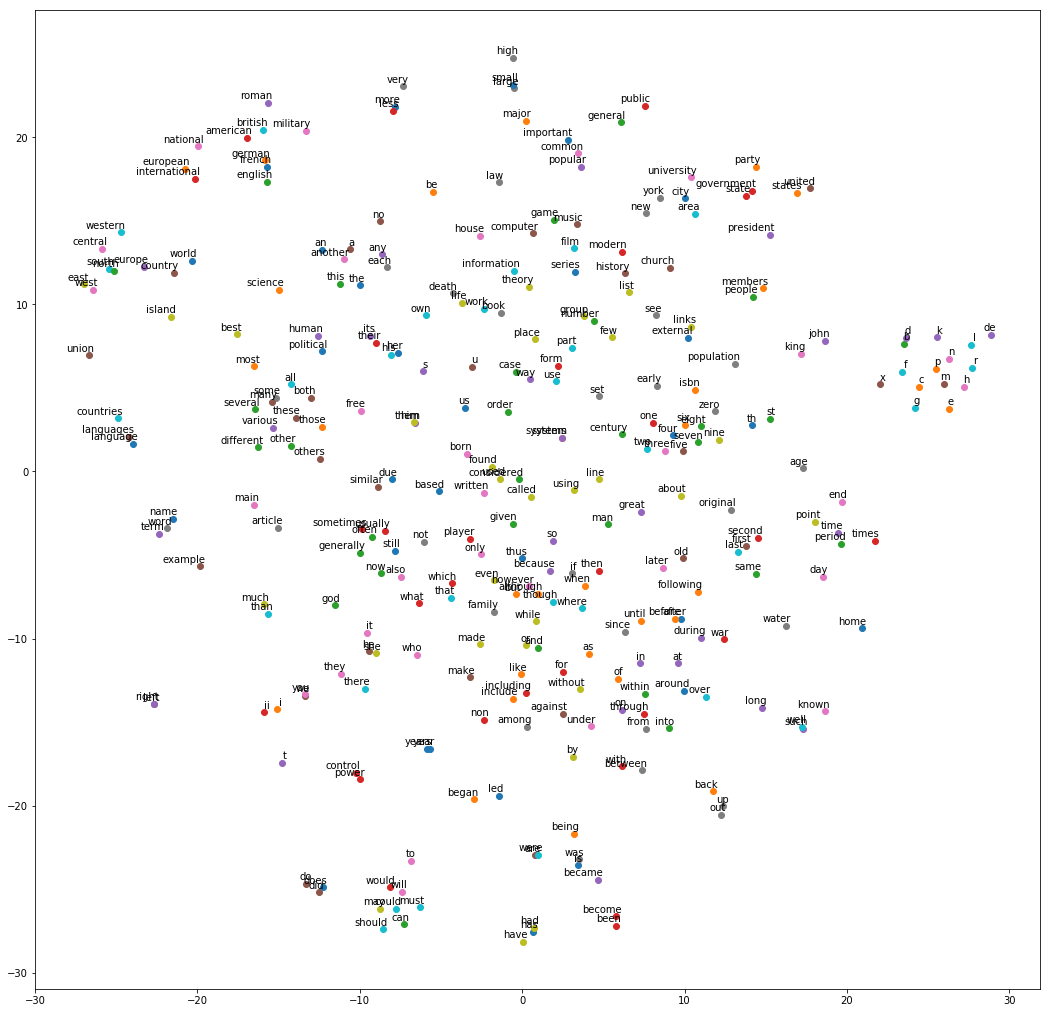

In [27]:
def plot_with_words(low_dim_embeddings, words):
  assert low_dim_embeddings.shape[0] >= len(words), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, words in enumerate(words):
    x, y = low_dim_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(words,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.show()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
n_embeddings = 300
low_dim_embeddings = tsne.fit_transform(final_embeddings[:n_embeddings, :])
words = [text8.id2word[i] for i in range(n_embeddings)]
  
plot_with_words(low_dim_embeddings, words)

# skip-gram model with Keras

In [28]:
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Reshape, Dot, merge
import keras

Using TensorFlow backend.


In [29]:
# reset the jupyter buffers
tf.reset_default_graph()
keras.backend.clear_session()

In [30]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [55 49 64 69 53 23 32 42]


In [31]:
embedding_size = 512  
n_negative_samples = 64
ptb.skip_window=2

In [32]:
sample_table = sequence.make_sampling_table(ptb.vocab_len)
pairs, labels= sequence.skipgrams(ptb.part['train'],
                        ptb.vocab_len,
                        window_size=ptb.skip_window,
                        sampling_table=sample_table)

In [33]:
print('The skip-gram pairs : target,context')
for i in range(5 * ptb.skip_window):
    print(['{} {}'.format(id,ptb.id2word[id]) for id in pairs[i]],':',labels[i])

The skip-gram pairs : target,context
['9307 r', "9 's"] : 1
['253 very', '190 markets'] : 0
['4130 i.', '1365 store'] : 1
['3962 encouraging', '1017 continuing'] : 0
['842 kong', '9728 lancaster'] : 0
['186 revenue', '6398 elements'] : 0
['870 disclosed', "32 n't"] : 1
['9817 scheduling', '1311 backed'] : 0
['5659 enjoyed', '153 industry'] : 1
['9343 reruns', '4351 rebounded'] : 0


In [34]:
x,y=zip(*pairs)
x=np.array(x,dtype=np.int32)
x=nputil.to2d(x,unit_axis=1)
y=np.array(y,dtype=np.int32)
y=nputil.to2d(y,unit_axis=1)
labels=np.array(labels,dtype=np.int32)
labels=nputil.to2d(labels,unit_axis=1)

In [35]:
# build the target word model
target_in = Input(shape=(1,),name='target_in')
target = Embedding(ptb.vocab_len,embedding_size,input_length=1,name='target_em')(target_in)
target = Reshape((embedding_size,1),name='target_re')(target)

# build the context word model
context_in = Input((1,),name='context_in')
context = Embedding(ptb.vocab_len,embedding_size,input_length=1,name='context_em')(context_in)
context = Reshape((embedding_size,1),name='context_re')(context)

# merge the models with the dot product to check for similarity and add sigmoid layer
output = Dot(axes=1,name='output_dot')([target,context])
output = Reshape((1,),name='output_re')(output)
output = Dense(1,activation='sigmoid',name='output_sig')(output)

# create the functional model for finding word vectors
model = Model(inputs=[target_in,context_in],outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

# merge the models and create model to check for cosine similarity
similarity = Dot(axes=0,normalize=True,name='sim_dot')([target,context])
similarity_model = Model(inputs=[target_in,context_in],outputs=similarity)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_in (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
context_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
target_em (Embedding)           (None, 1, 512)       5120000     target_in[0][0]                  
__________________________________________________________________________________________________
context_em (Embedding)          (None, 1, 512)       5120000     context_in[0][0]                 
__________________________________________________________________________________________________
target_re 

In [36]:
# train the model
n_epochs = 5
batch_size = 1024
model.fit([x,y],labels,batch_size=batch_size, epochs=n_epochs)

Epoch 1/5
1096180/1096180 [==============================] - 14s 13us/step - loss: 0.4492
Epoch 2/5
1096180/1096180 [==============================] - 14s 13us/step - loss: 0.2846
Epoch 3/5
1096180/1096180 [==============================] - 14s 13us/step - loss: 0.1079
Epoch 4/5
1096180/1096180 [==============================] - 14s 13us/step - loss: 0.0284
Epoch 5/5
1096180/1096180 [==============================] - 14s 13us/step - loss: 0.0213


In [37]:
# print closest words to validation set at end of training
top_k = 5  
y_val = np.arange(ptb.vocab_len, dtype=np.int32)
y_val = nputil.to2d(y_val,unit_axis=1)
for i in range(valid_size):
    x_val = np.full(shape=(ptb.vocab_len,1),fill_value=x_valid[i], dtype=np.int32)
    similarity_scores = similarity_model.predict([x_val,y_val])
    similarity_scores=similarity_scores.flatten()
    similar_words = (-similarity_scores).argsort()[1:top_k + 1]
    similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
    for k in range(top_k):
        similar_str = '{0:} {1:},'.format(similar_str, ptb.id2word[similar_words[k]])
    print(similar_str)

Similar to than: N, a, $, than, million,
Similar to his: do, did, from, to, of,
Similar to we: not, 're, did, it, n't,
Similar to last: year, month, N, <eos>, a,
Similar to u.s.: to, <eos>, said, as, in,
Similar to mr.: machines, was, said, co., years,
Similar to n't: did, does, wo, comment, would,
Similar to would: be, that, n't, if, should,


# word2vec or embeddings visualisation using TensorBoard

In [38]:
# clear the effects of previous sessions in the Jupyter Notebook
tf.reset_default_graph()

In [39]:
from tensorflow.contrib.tensorboard.plugins import projector

batch_size = 128
embedding_size = 128  
n_negative_samples = 64
ptb.skip_window=2

inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size],name='inputs')
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1],name='outputs')
inputs_valid = tf.constant(x_valid, dtype=tf.int32,name='inputs_valid')

# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word in the vocbulary

embed_matrix = tf.Variable(tf.random_uniform(shape=[ptb.vocab_len, embedding_size], 
                                           minval = -1.0, 
                                           maxval = 1.0
                                          ),
                           name='embed_matrix'
                        )
# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

# define noise-contrastive estimation (NCE) loss layer

nce_w = tf.Variable(tf.truncated_normal(shape=[ptb.vocab_len, embedding_size],
                                        stddev=1.0 / tf.sqrt(embedding_size*1.0)
                                       ),
                    name='nce_w'
                   )
nce_b = tf.Variable(tf.zeros(shape=[ptb.vocab_len]), name='nce_b')

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=ptb.vocab_len
                                    ),
                      name='nce_loss'
                     )

# Compute the cosine similarity between validation set samples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keep_dims=True),name='norm')
normalized_embeddings = tf.divide(embed_matrix,norm,name='normalized_embeddings')
embed_valid = tf.nn.embedding_lookup(normalized_embeddings, inputs_valid)
similarity = tf.matmul(embed_valid, normalized_embeddings, transpose_b=True, name='similarity')

n_epochs = 10
learning_rate = 0.9

n_batches = ptb.n_batches_wv()

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

log_dir = 'tflogs'

# save the vocabulary
vocabfile = 'word2id.tsv'
ptb.save_word2id(os.path.join(log_dir, vocabfile))

# create summary variable
tf.summary.scalar('epoch_loss_scalar',epoch_loss)
tf.summary.histogram('epoch_loss_histogram',epoch_loss)

merged = tf.summary.merge_all()
    

with tf.Session() as tfs:

    saver = tf.train.Saver()
    
    # Declare projector config
    config=projector.ProjectorConfig()

    # add embedding variable to the config
    embed_conf1 = config.embeddings.add()
    embed_conf1.tensor_name = embed_matrix.name
    embed_conf1.metadata_path = vocabfile
    
    
    file_writer = tf.summary.FileWriter(log_dir,tfs.graph)

    # save embeddings config that TensorBoard will read and visualize
    projector.visualize_embeddings(file_writer,config)
    


    tf.global_variables_initializer().run()

    for epoch in range(n_epochs):
        epoch_loss = 0
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil.to2d(y_batch,unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            summary, _, batch_loss = tfs.run([merged, optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
            saver.save(tfs, 
                       os.path.join(log_dir, 'model.ckpt'), 
                       global_step = epoch * n_batches + step)
        epoch_loss = epoch_loss / n_batches
        file_writer.add_summary(summary,global_step = epoch * n_batches + step)

        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)
        
        # print closest words to validation set at end of every epoch

        similarity_scores = tfs.run(similarity)
        top_k = 5  
        for i in range(valid_size):
            similar_words = (-similarity_scores[i, :]).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(similar_str, ptb.id2word[similar_words[k]])
            print(similar_str)
        
    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  0 :  113.313765391
Similar to than: a, teams, president, years, here,
Similar to his: six, money, department, types, he,
Similar to we: made, spending, as, major, share,
Similar to last: dodge, into, appeals, to, london,
Similar to u.s.: <unk>, export, said, latest, noted,
Similar to mr.: will, miles, company, page, 's,
Similar to n't: managers, $, preferences, the, new,
Similar to would: york, portfolios, N, montedison, she,

Average loss after epoch  1 :  49.7409719626
Similar to than: teams, declines, president, a, here,
Similar to his: six, money, department, uses, types,
Similar to we: made, spending, major, as, share,
Similar to last: appeals, dodge, into, thing, believe,
Similar to u.s.: latest, export, <unk>, commerce, nonexecutive,
Similar to mr.: will, contractor, miles, spokesman, status,
Similar to n't: managers, preferences, $, investment, cutting,
Similar to would: york, factors, portfolios, city, montedison,

Average loss after epoch  2 :  28.4

# The word2id and id2word code explained

In [40]:
import collections
counter=collections.Counter(['a','b','a','c','a','c'])
l=lambda x: (-x[1],x[0])
count_pairs=sorted(counter.items(),key=l)
words,_=list(zip(*count_pairs))
print(words)

word2id = dict(zip(words, range(len(words))))
print(word2id)
id2word = dict(zip(word2id.values(), word2id.keys()))
print(id2word)

('a', 'c', 'b')
{'c': 1, 'a': 0, 'b': 2}
{0: 'a', 1: 'c', 2: 'b'}
